<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png"/>

<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center>    

# Clasificación de textos con CNN. 

En este notebook, vamos a desarrollar un enfoque basado en un algoritmo clásico de aprendizaje automático. 

El dataset a utilizar es una colección de reviews de Amazon sobre Alexa. Este dataset puede descargarse desde este [link](#https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews) en Kaggle. 



## Dataset

In [2]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Colab Notebooks/data/alexa/"

Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_csv(PATH+"amazon_alexa.tsv",  sep='\t', on_bad_lines='skip') 
print('dataset cargado:', df.shape)

# nos quedamos únicamente con el texto y el campo de rating
df = df[['verified_reviews','rating']] 
# renombramos las columnas
df=df.rename(columns={"verified_reviews": "Text", "rating": "Label"})
df.head()


dataset cargado: (3150, 5)


,Text,Label
0,Love my Echo!,5
1,Loved it!,5
2,"Sometimes while playing a game, you can answer...",4
3,I have had a lot of fun with this thing. My 4 ...,5
4,Music,5


### Particiones

El dataset se distribuye en un único fichero. Debemos crear tres particiones distintas para entrenamiento, validación y evaluación final (test), con un ratio de 70:10:20.



In [4]:
from sklearn.model_selection import train_test_split
X=df['Text']
y=df['Label']

X_train, X_aux, y_train, y_aux = train_test_split(X, y, 
        test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, 
        test_size=2/3, random_state=42, stratify=y_aux)

print('Tamaño conjunto de entrenamiento:', len(X_train))
print('Tamaño conjunto de validación:', len(X_val))
print('Tamaño conjunto de evaluación:', len(X_test))


Tamaño conjunto de entrenamiento: 2205
Tamaño conjunto de validación: 315
Tamaño conjunto de evaluación: 630


### Distribución de clases



Distribución en training: {5: 1600, 4: 319, 1: 113, 3: 106, 2: 67}
Distribución en validación: {5: 229, 4: 45, 1: 16, 3: 15, 2: 10}
Distribución en test: {5: 457, 4: 91, 1: 32, 3: 31, 2: 19}
dict_keys([5, 4, 1, 3, 2])


Text(0, 0.5, 'Número de Instancias')

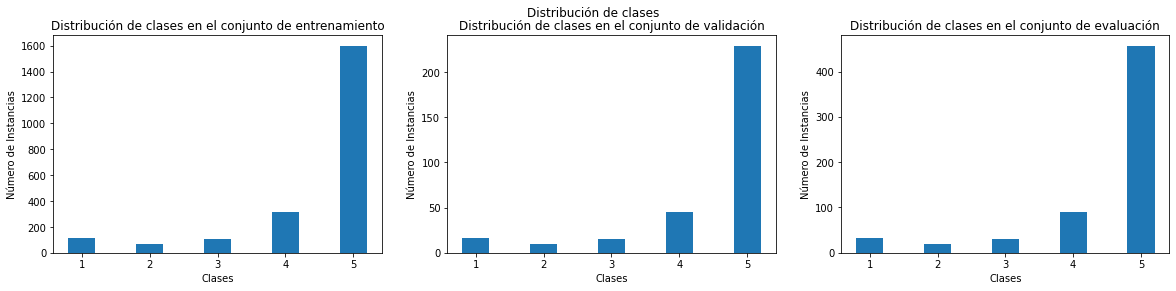

In [5]:
import matplotlib.pyplot as plt

counts_train = y_train.value_counts().to_dict()
print("Distribución en training:", counts_train)
counts_val = y_val.value_counts().to_dict()
print("Distribución en validación:", counts_val)
counts_test = y_test.value_counts().to_dict()
print("Distribución en test:", counts_test)

LABELS=counts_train.keys()
print(LABELS)


fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribución de clases')
ax_train.bar(LABELS, counts_train.values(), width=0.4)
ax_train.set_title('Distribución de clases en el conjunto de entrenamiento')
ax_train.set_xlabel('Clases')
ax_train.set_ylabel('Número de Instancias')

ax_val.bar(LABELS, counts_val.values(), width=0.4)
ax_val.set_title('Distribución de clases en el conjunto de validación')
ax_val.set_xlabel('Clases')
ax_val.set_ylabel('Número de Instancias')


ax_test.bar(LABELS, counts_test.values(), width=0.4)
ax_test.set_title('Distribución de clases en el conjunto de evaluación')
ax_test.set_xlabel('Clases')
ax_test.set_ylabel('Número de Instancias')

### Distribución del tamaño de los textos


Text(0, 0.5, 'Número de textos')

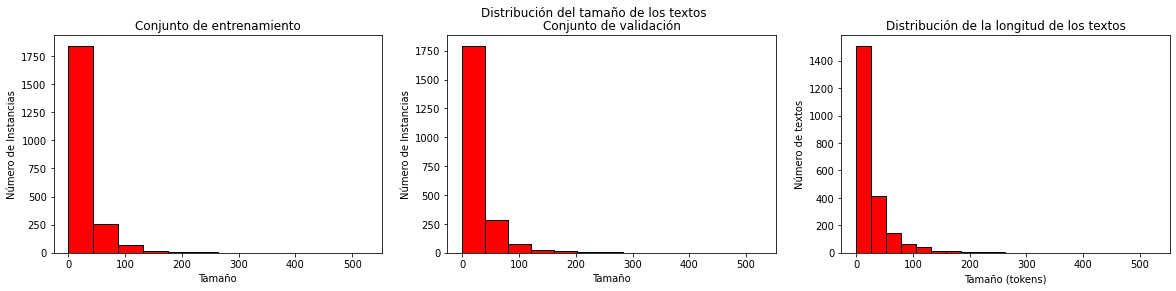

In [6]:
length_train=X_train.apply(lambda text: len(text.split()))
# length_train.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])
length_val=X_val.apply(lambda text: len(text.split()))
length_test=X_test.apply(lambda text: len(text.split()))

fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribución del tamaño de los textos')

ax_train.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(600/50))
ax_train.set_title('Conjunto de entrenamiento')
ax_train.set_xlabel('Tamaño')
ax_train.set_ylabel('Número de Instancias')

ax_val.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(200/15))
ax_val.set_title('Conjunto de validación')
ax_val.set_xlabel('Tamaño')
ax_val.set_ylabel('Número de Instancias')

ax_test.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(300/15))
ax_test.set_title('Conjunto test')
ax_test.set_xlabel('Tamaño')
ax_test.set_ylabel('Número de Instancias')

# Add labels
plt.title('Distribución de la longitud de los textos')
plt.xlabel('Tamaño (tokens)')
plt.ylabel('Número de textos')

Gracias a los tres gráficos, podemos afirmar que la distribución de las clases es similar en los tres subconjuntos de datos. 

## Label Encoding



In [7]:
LABELS = list(set(y_train))
print(LABELS)
NUM_LABELS = len(LABELS)


y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()


print(y_train[:10])

[1, 2, 3, 4, 5]
[5, 5, 5, 5, 5, 1, 5, 1, 2, 4]


In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()

print("antes de transform: ", y_train[:10])
y_train = le.fit_transform(y_train)
# las clases pasan de ser 1,2,3,4,5 a 0,1,2,3,4
print("después de transform:", y_train[:10])
# cada clase se representa como un vector one-hot de dimension 5
y_train_cat = to_categorical(y_train)
# print(y_train_cat[:10])

y_val = le.fit_transform(y_val)
y_val_cat = to_categorical(y_val)

print(y_test[:10])
y_test = le.fit_transform(y_test)
print(y_test[:10])

y_test_cat = to_categorical(y_test)


antes de transform:  [5, 5, 5, 5, 5, 1, 5, 1, 2, 4]
después de transform: [4 4 4 4 4 0 4 0 1 3]
[5, 5, 4, 5, 2, 5, 3, 4, 3, 5]
[4 4 3 4 1 4 2 3 2 4]


### Tokenización

Puedes consultar más información sobre el tokenizador de keras en este [link](#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).


In [9]:
X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

In [10]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token = True)
# entrenamos el tokenizador usando los textos del conjunto de entrenamiento
tokenizer.fit_on_texts(X_train)

# el índice 0, en principio, no ha sido asignado a ningún token y está reservado
# en nuestro caso, lo usamos para representar el token para padding
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario ={}".format(NUM_WORDS))


Tamaño del vocabulario =3740


El vocabulario consiste de una lista de las palabras de la colección del texto. Todos los signos de puntuación son eliminados. 

Vamos a mostrar algunas palabras del vocabulario y su índice.



In [11]:
for (word,index) in tokenizer.word_index.items():
    print(index,word)
    if index==20:
        break

1 True
2 the
3 i
4 to
5 it
6 and
7 a
8 my
9 is
10 for
11 love
12 echo
13 this
14 with
15 of
16 have
17 great
18 that
19 in
20 but


El tokenizador nos permite representar los textos como una secuencia de enteros. Es decir cada palabra es reemplazada por su índice en el vocabulario. 

In [12]:
# Cada texto es transformado en una secuencia de enteros. 
# En el vocabulario, cada palabra tiene asociado un entero

encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_val = tokenizer.texts_to_sequences(X_val)
encoded_test = tokenizer.texts_to_sequences(X_test)

# print(X_train[4])
# print(encoded_train[4])
for i in range(5):
    print(X_train[i])
    print(encoded_train[i], " len:", len(encoded_train[i]))
    print()



Great!!
[17]  len: 1

Echos are great I have a few of them through out our home .  All in voice range to ask a question. Say a command to turn lights on or off. Or my favorite is play music all though the house.
[362, 52, 17, 3, 16, 7, 234, 15, 129, 183, 71, 72, 61, 34, 19, 125, 786, 4, 126, 7, 587, 166, 7, 336, 4, 147, 138, 22, 49, 112, 49, 8, 295, 9, 68, 28, 34, 228, 2, 127]  len: 40

Excellent product, mint condition for a refurbished unit - you would never know it's been refurbished!
[395, 54, 2167, 723, 10, 7, 186, 348, 24, 63, 282, 134, 60, 141, 186]  len: 15

This was just an additional one for my other TV. Loved it so much use it on the regular TV. Easy to set up and fairly easy to navigate. I don’t waste my money on regular TV cable or anything else. This is enough for me as I don’t watch too much TV.
[13, 31, 40, 48, 629, 36, 10, 8, 73, 110, 245, 5, 23, 75, 32, 5, 22, 2, 433, 110, 42, 4, 43, 30, 6, 787, 42, 4, 1275, 3, 241, 724, 8, 273, 22, 433, 110, 414, 49, 255, 305, 13, 9,

Podemos ver que cada secuencia tiene un tamaño distinto. Nuestro modelo necesita que todas las secuencias tengan la misma longitud. ¿Cómo podemos estimar la longitud más apropiadas?

Sabemos que la secuencia más larga es de 526 tokens, sin embargo, vemos que el 99% de las oraciones tienen menos de 170 tokens y el 90% tienen menos de 60 tokens. Por tanto, si elegimos 526 como el tamaño de la secuencia, estaríamos desperdiciando mucha memoria (el tamaño medio es solo de 26 tokens).



In [13]:
length_train.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])


count    2205.000000
mean       26.170522
std        36.618675
min         0.000000
25%         6.000000
50%        15.000000
75%        32.000000
90%        60.000000
95%        86.800000
99%       171.000000
max       526.000000
Name: Text, dtype: float64


Vamos a considerar el tamaño máximo como 60 tokens. Se aplicará padding (añadir el token espacial <pad>) a las oraciones con una longitud menor de 60 tokens. Por el contrario, si la oración tiene una longitud mayor, será truncada. Se puede elegir si el padding (o el trunking) es aplicado al principio o final de la oración. Por defecto, siempre se añade el padding y se realiza el trunking al principio de la oración. 

In [14]:
MAX_LEN=60

Aplicamos el método pad_sequences que se encargará tanto del padding como del recortar las oraciones con una longitud mayor a 60 tokens. Hemos decidido aplicare el padding al final de la oración (post). No decimos nada respecto al truncating, por tanto, las oraciones con una longitud mayor a 60 serán recortadas en el principio (por defecto). 

In [15]:
from keras.utils import pad_sequences 

encoded_train = pad_sequences(encoded_train, maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(encoded_val, maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

In [16]:
for i in range(3):
    print(X_train[i])
    print(encoded_train[i], " len:", len(encoded_train[i]))
    print()

Great!!
[17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]  len: 60

Echos are great I have a few of them through out our home .  All in voice range to ask a question. Say a command to turn lights on or off. Or my favorite is play music all though the house.
[362  52  17   3  16   7 234  15 129 183  71  72  61  34  19 125 786   4
 126   7 587 166   7 336   4 147 138  22  49 112  49   8 295   9  68  28
  34 228   2 127   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]  len: 60

Excellent product, mint condition for a refurbished unit - you would never know it's been refurbished!
[ 395   54 2167  723   10    7  186  348   24   63  282  134   60  141
  186    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  

## CNN

In [17]:
import tensorflow as tf 
tf.__version__

'2.9.2'

In [18]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

EMBEDDING_SIZE=200
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 200)           748000    
                                                                 
 conv1d (Conv1D)             (None, 60, 128)           102528    
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 64)            32832     
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 32)            8224      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                        

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Save the model after every epoch.
# saveBestModel = ModelCheckpoint(root+'CNNbest.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


### Training

In [24]:
# Entrenamos el modelo
epochs = 20 # número de veces que pasamos sobre el conjunto de aprendizaje

#número de ejemplos que procesamos antes de acutalizar los pesos
# El tamaño del conjunto aprendizaje es 2205, 2205/16 = 138. 
# En cada epoch, entrenamos 138 veces y actualizamos
batch_size = 16 

# training
# history=model.fit(encoded_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val_cat), callbacks=[earlyStopping])
history=model.fit(encoded_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val_cat))


Epoch 1/20
138/138 [==============================] - 1s 6ms/step - loss: 0.0727 - accuracy: 0.9737 - val_loss: 2.0997 - val_accuracy: 0.7016
Epoch 2/20
138/138 [==============================] - 1s 5ms/step - loss: 0.0732 - accuracy: 0.9787 - val_loss: 2.0953 - val_accuracy: 0.7460
Epoch 3/20
138/138 [==============================] - 1s 5ms/step - loss: 0.0535 - accuracy: 0.9819 - val_loss: 2.4561 - val_accuracy: 0.7333
Epoch 4/20
138/138 [==============================] - 1s 5ms/step - loss: 0.0543 - accuracy: 0.9800 - val_loss: 2.3276 - val_accuracy: 0.7460
Epoch 5/20
138/138 [==============================] - 1s 5ms/step - loss: 0.0515 - accuracy: 0.9819 - val_loss: 2.7011 - val_accuracy: 0.7587
Epoch 6/20
138/138 [==============================] - 1s 5ms/step - loss: 0.0505 - accuracy: 0.9819 - val_loss: 2.5888 - val_accuracy: 0.7397
Epoch 7/20
138/138 [==============================] - 1s 5ms/step - loss: 0.0485 - accuracy: 0.9832 - val_loss: 2.7201 - val_accuracy: 0.7460
Epoch 

### Curvas de aprendizaje

En las curva de aprenzije, el modelo es evaluado en el conjunto de entrenamiento para saber cómo de bien el modelo es capaz de aprender.
Además, el modelo también se evalúa en el conjunto de validación para saber cómo de bien el modelo es capaz de generalizar. 

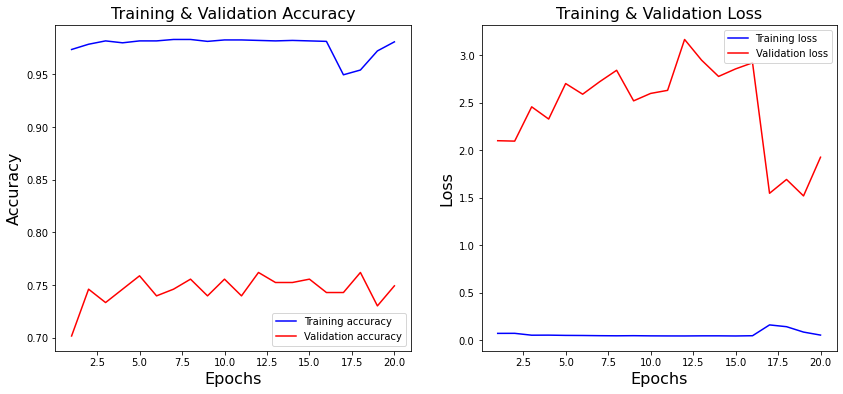

In [25]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

### Evaluación

In [26]:
loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)
# El tamaño del conjunto test es de 630
# SE evalua en batch de 16: 630 / 16 = 40 veces

40/40 [==============================] - 0s 5ms/step - loss: 1.7300 - accuracy: 0.7810


También podemos hacer la evaluación usando las función **classification_report** que nos dará más información sobre los resultados para cada clase:

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report 

y_pred = np.argmax(model.predict(encoded_test), axis=1)
print(y_pred[0:10])
print('accuracy:', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=['1','2','3','4','5']))

20/20 [==============================] - 0s 6ms/step
[3 4 3 4 3 4 2 4 2 4]
accuracy: 0.780952380952381
              precision    recall  f1-score   support

           1       0.38      0.25      0.30        32
           2       0.43      0.32      0.36        19
           3       0.70      0.52      0.59        31
           4       0.52      0.55      0.53        91
           5       0.87      0.90      0.88       457

    accuracy                           0.78       630
   macro avg       0.58      0.51      0.53       630
weighted avg       0.77      0.78      0.77       630

